# VES Experiments for 1D Bayesian Optimization

In [4]:
from ves.ves_legacy import VariationalEntropySearch
import matplotlib.pyplot as plt
import numpy as np
import torch

/tmp/ipykernel_156227/743885723.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_X = torch.load('1D_train_X.pt')# fix initial points


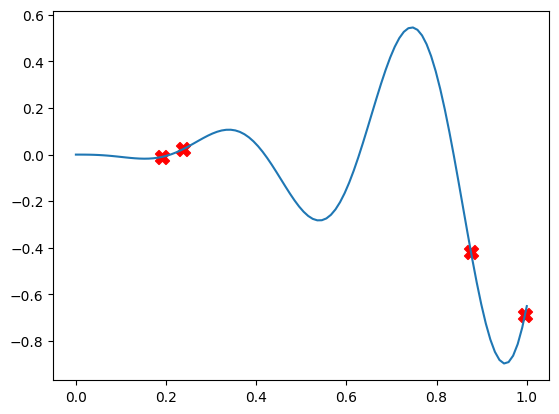

In [5]:
train_X = torch.load('1D_train_X.pt')# fix initial points
def f(X, noise=0.0):
    return -np.sin(15*X)*X**2
train_Y = f(train_X, noise=0.0)
bounds = torch.Tensor([[torch.zeros(1), torch.ones(1)]])

# plot function f
tx = torch.linspace(0,1,100)
plt.plot(tx.squeeze().numpy(),f(tx).squeeze().numpy())
plt.scatter(train_X.numpy(),train_Y.numpy(),c='r',s=100,marker='X')
plt.show()

In [6]:
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.sampling.pathwise import draw_matheron_paths
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.max_value_entropy_search import qMaxValueEntropy
NUM_PATHS = 1024
outcome_transform = Standardize(m=1)
gp = SingleTaskGP(train_X, train_Y, outcome_transform=outcome_transform) # gp model
mll = ExactMarginalLogLikelihood(gp.likelihood, gp) # mll object
_ = fit_gpytorch_mll(mll) # fit mll hyperpara
best_f = train_Y.max()
paths = draw_matheron_paths(gp, torch.Size([NUM_PATHS]))
ves_model = VariationalEntropySearch(gp, best_f=best_f, bounds=bounds, paths=paths)
ei_model = ExpectedImprovement(gp, best_f=best_f)
X = torch.linspace(0, 1, 201).unsqueeze(-1).to(torch.double)
mes_model = qMaxValueEntropy(gp, candidate_set=X)

/home/leonard/IdeaProjects/variational-entropy-search/venv/lib/python3.12/site-packages/botorch/acquisition/analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


In [7]:
def dt(d): return d.detach().numpy()
kvals, betavals, _, val = ves_model(X, return_ves=True)
ei = ei_model(X.unsqueeze(-1))
mes = mes_model(X.unsqueeze(-1))
val = dt(val.flatten())
val = (val - np.mean(val))/np.std(val)
ei = dt(ei.flatten())
ei = (ei - np.mean(ei))/np.std(ei)
mes = dt(mes.flatten())
mes = (mes - np.mean(mes))/np.std(mes)

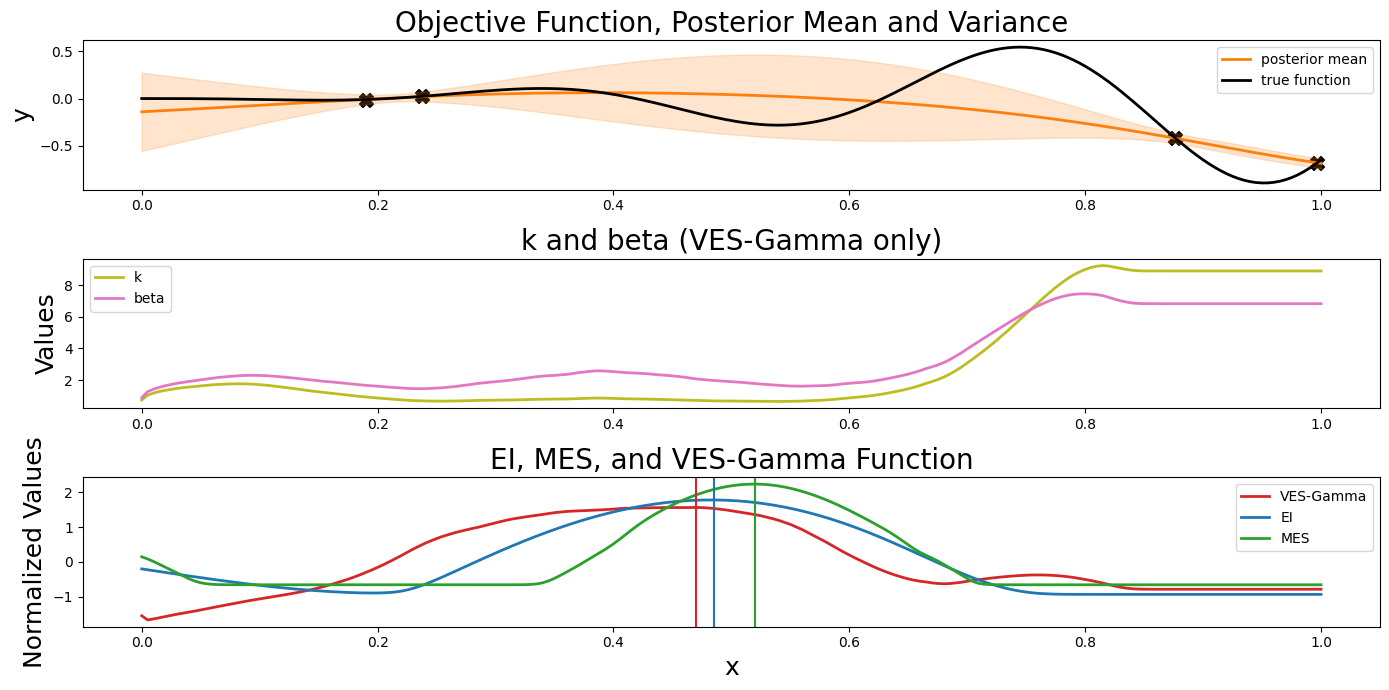

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(14, 7))

posterior = gp.posterior(X)
m = dt(posterior.mean)
s = dt(posterior.variance.sqrt())
axes[0].plot(dt(X).flatten(), m.flatten(), linewidth=2, label='posterior mean', color='tab:orange')
if train_X is not None and f is not None:
    axes[0].plot(dt(X).flatten(), f(X).flatten(), linewidth=2, label='true function', color='black')
    axes[0].scatter(dt(train_X).flatten(), dt(train_Y).flatten(), marker='X', s=100, color='black')
else:
    axes[0].scatter(dt(gp.train_inputs[0]), dt(gp.train_targets))
axes[0].fill_between(dt(X).flatten(), (m - 2 * s).flatten(), (m + 2 * s).flatten(), alpha=0.2, color='tab:orange')
axes[0].legend()
axes[0].set_title('Objective Function, Posterior Mean and Variance', fontsize=20)
axes[0].set_ylabel('y', fontsize=18)

axes[1].plot(X.flatten(), dt(kvals.flatten()), linewidth=2, label=f'k', color='tab:olive')
axes[1].plot(X.flatten(), dt(betavals.flatten()), linewidth=2, label=f'beta', color='tab:pink')
axes[1].set_title('k and beta (VES-Gamma only)', fontsize=20)
axes[1].set_ylabel('Values', fontsize=18)

axes[2].plot(X.flatten(), val, label=f'VES-Gamma', linewidth=2, color='tab:red')
axes[2].plot(X.flatten(), ei, label=f'EI'.upper(), linewidth=2, color='tab:blue')
axes[2].plot(X.flatten(), mes, label=f'MES'.upper(), linewidth=2, color='tab:green')
axes[2].axvline(X.flatten()[val.argmax()], label=f'__nolabel__', color='tab:red')
axes[2].axvline(X.flatten()[ei.argmax()], label=f'__nolabel__', color='tab:blue')
axes[2].axvline(X.flatten()[mes.argmax()], label=f'__nolabel__', color='tab:green')
axes[2].set_title('EI, MES, and VES-Gamma Function', fontsize=20)
axes[2].set_xlabel('x', fontsize=18)
axes[2].set_ylabel(r'Normalized Values', fontsize=18)

plt.tight_layout()
axes[1].legend()
axes[2].legend()
# fig.savefig('ves_1d_small.pdf', dpi=300)